In [1]:
from os import remove
from os.path import join
from re import compile, search, findall
from numpy import (
    ndarray,
    array,
    ascontiguousarray,
    zeros,
    empty,
    any,
    diagonal,
    int64,
    float64,
    complex128,
)
from h5py import File
from typing import Tuple
from numpy.linalg import eigh, eigvalsh



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def gaussian(x, mu, sigma, area):
    normalization = area / (sigma * np.sqrt(2 * np.pi))
    return normalization * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def lorentzian(x, mu, gamma, area):
    
    return area / (np.pi) * (gamma) / ((x - mu)**2 + gamma**2)
def convolute_spectral_lines_l(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += lorentzian(x_values, energy, sigma, area)

    return x_values, conv_spectrum

def convolute_spectral_lines_g(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += gaussian(x_values, energy, sigma, area)

    return x_values, conv_spectrum
def relative_boltzmann_distribution(x, y, T):

    k = 3.166811563e-6  # Boltzmann constant in a.u./K
    delta_E = y - x   # Energy difference

    return np.exp(-delta_E / (k * T)) 

In [3]:
def _get_orca_blocks_size_new(orca_filepath: str) -> tuple[int, int, int]:
    
    with open(orca_filepath, "r") as file:
        regex = compile(r"SOC MATRIX \(A\.U\.\)\n")
        so_dim = -1
        for line in file:
            if regex.search(line):
                for _ in range(4):
                    file.readline()
                for line in file:
                    elements = findall(r'[-+]?\d*\.\d+|[+-]?\d+', line)
                    so_dim += 1
                    if len(elements) == 6:
                        break
                break


 

    num_blocks = so_dim // 6
    num_of_whole_blocks = num_blocks
    remaining_columns = so_dim % 6

    if remaining_columns != 0:
        num_blocks += 1 


    return so_dim, num_of_whole_blocks, remaining_columns

In [4]:
def _orca_reader(
    so_dim: int,
    num_of_whole_blocks: int,
    remaining_columns: int,
    file, #passing the open file
) -> array:
    matrix = empty((so_dim, so_dim), dtype=float64)
    l = 0
    for _ in range(num_of_whole_blocks):
        file.readline()  # Skip a line before each block of 6 columns
        for i in range(so_dim):
            line = file.readline()
            elements = findall(r'[-+]?\d*\.\d+', line)
            for j in range(6):       
                matrix[i, l + j] = float64(elements[j])
        l += 6
        
    if remaining_columns > 0:
        file.readline()  # Skip a line before the remaining columns
        for i in range(so_dim):
            line = file.readline()
            elements = findall(r'[-+]?\d*\.\d+', line)
            for j in range(remaining_columns):
                matrix[i, l + j] = float64(elements[j])

    return matrix
    

In [5]:
def _orca_to_slt(orca_filepath: str, slt_filepath: str, group_name: str, pt2: bool, electric_dipole_momenta: bool, ssc: bool) -> None:
    
    # Retrieve dimensions and block sizes for spin-orbit calculations
    (so_dim, num_of_whole_blocks, remaining_columns) = _get_orca_blocks_size_new(orca_filepath)
    
    # Create HDF5 file and ORCA group
    with File(f"{slt_filepath}", "a") as slt:
        group = slt.create_group(group_name)
        group.attrs["Type"] = "HAMILTONIAN"
        group.attrs["Kind"] = "ORCA"
        if ssc:
            group.attrs["Energies"] = "SSC_ENERGIES"
        else:
            group.attrs["Energies"] = "SOC_ENERGIES" 
        if electric_dipole_momenta:
            group.attrs["Additional"] = "ELECTRIC_DIPOLE_MOMENTA"
        group.attrs["Description"] = "Relativistic ORCA results."

        # Extract and process matrices
        pattern_type = [[r"SOC and SSC MATRIX\s*\(A\.U\.\)\s*"]] if ssc else [[r"SOC MATRIX\s*\(A\.U\.\)\s*"]]
        pattern_type += [[r"SX MATRIX IN CI BASIS\n", r"SY MATRIX IN CI BASIS\n", r"SZ MATRIX IN CI BASIS\n"], [r"LX MATRIX IN CI BASIS\n", r"LY MATRIX IN CI BASIS\n", r"LZ MATRIX IN CI BASIS\n"]]
        matrix_type = ["STATES_ENERGIES", "SPINS", "ANGULAR_MOMENTA"]
        descriptions = ["States energies.", "Sx, Sy, and Sz spin matrices in the SOC basis [(x-0, y-1, z-2), :, :].", "Lx, Ly, and Lz angular momentum matrices in the SOC basis [(x-0, y-1, z-2), :, :]."]

        if electric_dipole_momenta:
            #pattern_type.append([r"Matrix TX", r"Matrix TY", r"Matrix TZ"])
            
            pattern_type.append([r"Matrix EDX in CI Basis\n", r"Matrix EDY in CI Basis\n", r"Matrix EDZ in CI Basis\n"])
            matrix_type.append("ELECTRIC_DIPOLE_MOMENTA")
            descriptions.append("Px, Py, and Pz electric dipole momentum")
            
        final_number = (3 if ssc else 1) + (1 if pt2 else 0)
        energy_final_number = 2 if pt2 else 1

        for matrix, patterns, description in zip(matrix_type, pattern_type, descriptions):
            if matrix == "STATES_ENERGIES":
                dataset = group.create_dataset(f"{matrix}", shape = so_dim, dtype = float64, chunks = True)
            else:
                dataset = group.create_dataset(f"{matrix}", shape = (3, so_dim, so_dim), dtype = complex128, chunks = True)
            
            dataset.attrs["Description"] = description

            for index, pattern in enumerate(patterns):
                regex = compile(pattern)
          
                with open(f"{orca_filepath}", "r") as file:
                    matrix_number = 0
                    for line in file:
                        if regex.search(line):
                            matrix_number += 1
                            if matrix == "STATES_ENERGIES":
                                final_number =  energy_final_number  
                            if matrix_number == final_number:
                                print(matrix_number)
                                #for _ in range(1):
                                        #line=file.readline()
                                        #print(line)
                                if matrix != "ELECTRIC_DIPOLE_MOMENTA":
                                    for _ in range(3):
                                        file.readline() # Skip the first 3 lines if not electric dipole momenta
                                else:
                                    for _ in range(0):
                                        line=file.readline()
                                        print(line)
                                data = _orca_reader(so_dim, num_of_whole_blocks, remaining_columns, file)
                                if matrix == "ELECTRIC_DIPOLE_MOMENTA":
                                    print(data)
                                if matrix == "STATES_ENERGIES":
                                    for _ in range(2):
                                        file.readline()  # Skip 2 lines separating real and imaginary part
                                    data_imag = _orca_reader(so_dim, num_of_whole_blocks, remaining_columns, file)
                                    energy_matrix = array(data + 1j * data_imag, dtype=complex128)
                                    energies, eigenvectors = eigh(energy_matrix)
                                    dataset[:] = energies - min(energies)  # Assign energies to the dataset
                                else:
                                   
                                    transformed_data = (eigenvectors.conj().T @ data @ eigenvectors)
                                    dataset[index] = transformed_data[:]# Assign transformed matrix

                                break

            


In [6]:
_orca_to_slt('Yb_bpdo_casscf_nevpt2_dipmom2_x2c.out', 'Nd_CN_MeOH', 'bas5', False, True, False)

1
1
1
1
1
1
1
1
[[-0.        0.237271  0.011171  0.000768 -0.042795 -0.171818 -0.0075
   0.        0.        0.        0.        0.        0.        0.      ]
 [-0.237271  0.        0.001567 -0.008209  0.006014 -0.004354  0.046066
   0.        0.        0.        0.        0.        0.        0.      ]
 [-0.011171 -0.001567  0.        0.036444 -0.014314  0.007873 -0.003915
   0.        0.        0.        0.        0.        0.        0.      ]
 [-0.000768  0.008209 -0.036444 -0.        0.002886 -0.022463 -0.007656
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.042795 -0.006014  0.014314 -0.002886 -0.        0.012043 -0.05335
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.171818  0.004354 -0.007873  0.022463 -0.012043 -0.       -0.19776
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.0075   -0.046066  0.003915  0.007656  0.05335   0.19776  -0.
   0.        0.        0.        0.        0.       

In [11]:
with File('Nd_CN_MeOH', 'r') as file:

    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print("    %s: %s" % (key, val))

    #file.visititems(print_attrs)
    data = file['bas5/STATES_ENERGIES'][:]
    dipmom = zeros((3,14, 14), dtype=complex128)
    dipmom[0][:] = file['bas5/ELECTRIC_DIPOLE_MOMENTA'][0]
    dipmom[1][:] = file['bas5/ELECTRIC_DIPOLE_MOMENTA'][1]
    dipmom[2][:]=file['bas5/ELECTRIC_DIPOLE_MOMENTA'][2]

    
   # data = 1e7/(data*219474.6)
    data=data-data[0]
    data = 1e7/(data*219474.6)
    print(data)

[           inf 6.26218038e+12 6.55904898e+03 6.55904897e+03
 3.82028046e+03 3.82028046e+03 3.00941268e+03 3.00941268e+03
 2.29861056e+03 2.29861056e+03 1.97156840e+03 1.97156840e+03
 1.49179006e+03 1.49179006e+03]


/tmp/ipykernel_3035931/1327716648.py:18: RuntimeWarning: divide by zero encountered in divide
  data = 1e7/(data*219474.6)


[ 787.70910854  787.70910859  795.79809891  795.79809893  799.2651256
  799.26512575  800.70794506  800.70794511  811.47706061  811.47706085
  937.86539505  937.86539509  940.06616144  940.06616151  942.89500339
  942.89500346  945.56905356  945.56905371  951.99071545  951.99071549
  953.38369212  953.38369226 1160.85978254 1160.85978254 1164.35903471
 1164.35903476 1167.9001387  1167.90013898 1172.75410478 1172.75410489
 1185.24137358 1185.24137364 1186.36847174 1186.36847235 1189.62958987
 1189.62958998 1525.85125673 1525.85125729 1535.9700026  1535.97000279
 1551.8072343  1551.80723468 1558.71755168 1558.71755207 1597.34816273
 1597.34816324 1610.05499808 1610.05499912 1617.37527656 1617.37527729
 1626.13766348 1626.13766369]
[4.92067548e-06 2.01444007e-06 6.42313484e-06 2.34863785e-06
 3.45739430e-06 3.88936181e-06 8.46882017e-07 1.22283000e-06
 5.51889472e-06 4.08790521e-06 5.02060165e-06 1.09639035e-05
 9.65022131e-06 1.01228926e-05 1.26633664e-05 2.56626145e-06
 8.82130355e-07 4

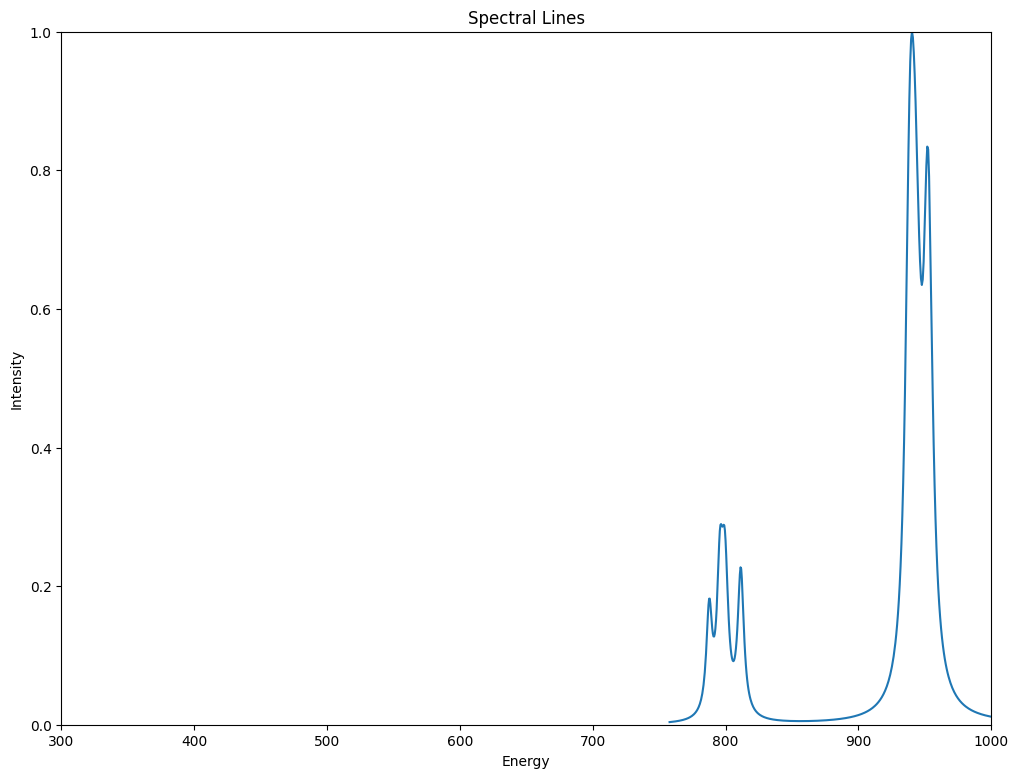

In [9]:
import numpy as np

F =[[52]]#, 109, 110, 111, 112, 113, 114, 115, 116, 118]]

temperatures = np.linspace(10,10, 1)
fwhm = 100
normalize = 1
resolution = 1000
sum_spectra = np.zeros((resolution, ), dtype=np.float64)


fig, axs = plt.subplots(1, 1, figsize=(12, 9))

energies = data[:]

energies = (energies - energies[0])

for index, F_emissive in enumerate(F):
    for T in temperatures:    
        intensities = np.zeros((len(F_emissive),F[0][0]), dtype = np.float64)
        emission_energies_cm = np.zeros((len(F_emissive), F[0][0]), dtype = np.float64)
        for l, level in enumerate(F_emissive):
            for i in range(F[0][0]):
                for k in range(3):
                    intensities[l,i] += relative_boltzmann_distribution(energies[F_emissive[0]], energies[level], T) * 2/3 * np.abs(dipmom[k, i, level])**2 * (energies[level] - energies[i])
                    emission_energies_cm[l,i] = ((energies[level] - energies[i]) * 219474.6)
        intensities = intensities.flatten()
        emission_energies_cm = emission_energies_cm.flatten()
    
        intensities = intensities#/max(intensities)
        emission_energies_cm=emission_energies_cm
        emission_energies_nm = 1e7/emission_energies_cm
        print(emission_energies_nm[:])
        energy_x_cm, spectrum = convolute_spectral_lines_l(emission_energies_cm, intensities, fwhm, resolution)
        spectrum = spectrum/max(spectrum) 
        sum_spectra += spectrum
        energy_x_nm = 1e7/energy_x_cm
      
        
        
    
        
    
axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}')


print(intensities)   


axs.set_xlabel('Energy')
axs.set_ylabel('Intensity')
axs.set_title('Spectral Lines')
axs.set_xlim([300, 1000])
axs.set_ylim([0,1])
intensities=intensities*1e6
df=pd.DataFrame({'x':energy_x_nm,'sp':spectrum})
df2=pd.DataFrame({'en':emission_energies_nm.round(1),'int':intensities.round(1)})
df.to_csv('Nd_CN_pt2_spectrum_em2')
df2.to_csv('Nd_CN_pt2_int_em2')

(1.1434002194945535e-16+0.5676627092252857j)
[787.70910854 787.70910847 785.14352606 785.14352598 736.41811997
 736.4181199  733.08394286 733.08394284 732.12168664 732.12168657
 728.43829159 728.43829152 727.88885433 727.88885431 726.8277147
 726.82771468 724.87919963 724.87919952 723.7961895  723.79618947
 682.43270307 682.43270294 682.31775853 682.31775843 678.66797002
 678.66797    677.93880412 677.93880411 674.68053109 674.68053105
 673.73787083 673.73787083 625.28814037 625.28814032 624.64807248
 624.6480724  623.33082642 623.33082637 620.91307125 620.91307116
 619.62102799 619.62102789 589.64137488 589.64137486 588.61854223
 588.61854207 586.90182117 586.90182114 585.77636908 585.77636901
 583.52816539 583.52816539 583.41227096 583.41227094 534.25316007
 534.25316007 532.72037529 532.72037528 531.64804237 531.64804236
 531.23958618 531.23958616 519.4469297  519.44692967 517.3645264
 517.36452638 513.35232291 513.35232285 477.31757039 477.31757035
 476.5734159  476.57341587 475.15

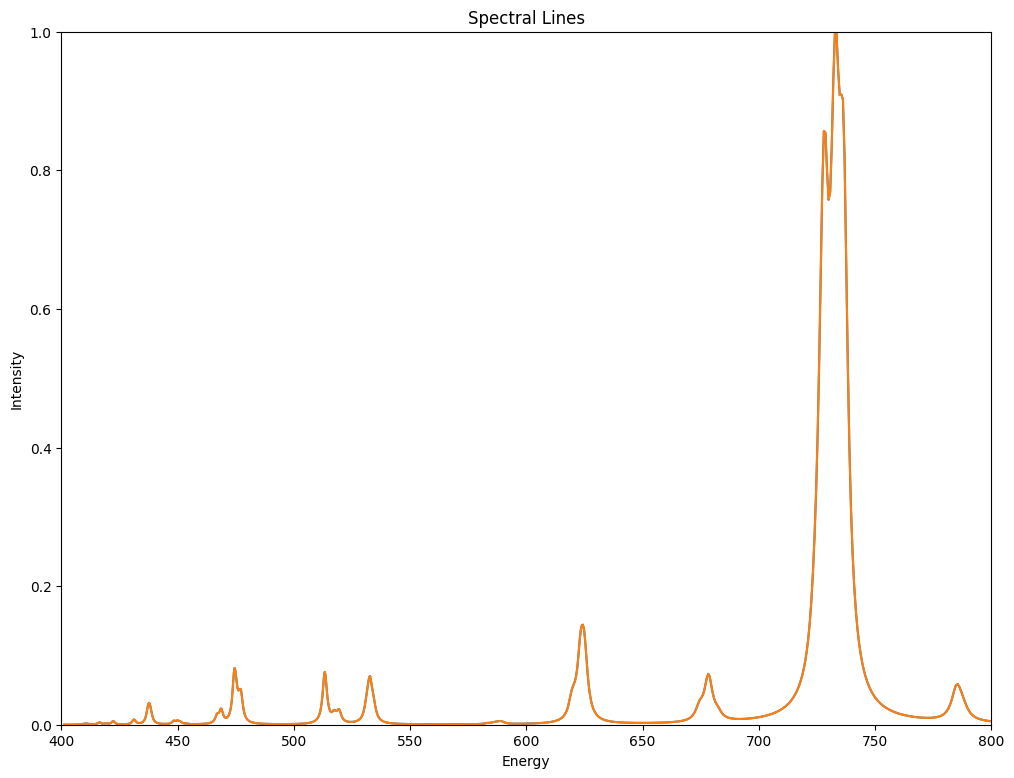

In [12]:
#ABSORPTION
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
F = [em]
temperatures = np.linspace(10,10, 1)
fwhm = 100
normalize = 1
resolution = 1000
sum_spectra = np.zeros((resolution, ), dtype=np.float64)


fig, axs = plt.subplots(1, 1, figsize=(12, 9))



energies = data[:]
energies = (energies - energies[0])
#dipmom = dip_mom_soc[:]
print(dipmom[0][0][0])

  
for index, F_emissive in enumerate(F):
    for T in temperatures:    
        intensities = np.zeros((len(F_emissive),1), dtype = np.float64)
        emission_energies_cm = np.zeros((len(F_emissive), 1), dtype = np.float64)
        
        for l, level in enumerate(F_emissive):
            for i in range(1):
                for k in range(3):
                    intensities[l,i] += 2/3 * np.abs(dipmom[k, i, level])**2 * (energies[level] - energies[0])
                    emission_energies_cm[l,i] = ((energies[level] - energies[0]) * 219474.6)
        intensities = intensities.flatten()
        emission_energies_cm = emission_energies_cm.flatten()
        intensities = intensities#/max(intensities)
        
        emission_energies_nm = 1e7/emission_energies_cm
        energy_x_cm, spectrum = convolute_spectral_lines_l(emission_energies_cm, intensities, fwhm, resolution)
        spectrum = spectrum/max(spectrum) 
        sum_spectra += spectrum
        energy_x_nm = 1e7/energy_x_cm
      
        
        
    
print(emission_energies_nm)        
print(intensities)
axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}')


        


axs.set_xlabel('Energy')
axs.set_ylabel('Intensity')
axs.set_title('Spectral Lines')
axs.set_xlim([400, 800])
axs.set_ylim([0,normalize])

axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}') 


intensities=intensities*1e6
df=pd.DataFrame({'x':energy_x_nm,'sp':spectrum})
df2=pd.DataFrame({'en':emission_energies_nm.round(1),'int':intensities.round(1)})
df.to_csv('Nd_CN_ab_intspectrum')
df2.to_csv('Nd_CN_ab_int')  

In [11]:
import numpy as np
em1 = np.linspace(52,190,139)
em=[]
for i in em1:
    em.append(int(i))
em  

[52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190]